# Опредение возраста по фотографии

Определение возраста покупателей
Сфера деятельности - продажи.

Необходимо определить возраст клиентов для того, чтобы проанализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, и для контроля добросовестности кассиров при продаже алкогольной и никотиновой продукций.

Входные данные – фотографии людей и их возраст.

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale = 1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = '/datasets/faces/final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        seed = 12345)

Found 7591 validated image filenames.


In [ ]:
# Размер выборки
labels.shape

(7591, 2)

In [ ]:
distribution_age = labels.groupby('real_age')['file_name'].count()
distribution_age

real_age
1      149
2       88
3       25
4      101
5       87
      ... 
94       5
95       2
96       2
97       1
100      1
Name: file_name, Length: 97, dtype: int64

Text(0.5, 1.0, 'distribution_age')

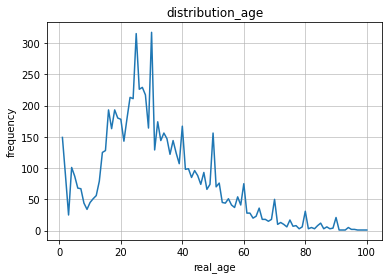

In [ ]:
# Построим график распределения возраста в выборке
distribution_age.plot()
plt.grid(alpha=0.75)
plt.xlabel('real_age')
plt.ylabel('frequency')
plt.title('distribution_age')
# Распределение похоже на нестандартное нормальное, область значение которого перенеслась на значение мат. ожидания 
# в отличии от стандартного нормального распределения.

# На графике видно, что наибольшее количество данных приходится на возраст 20-30 лет.
# В других категориях, например, 0-10 или 60-70 лет, данных намного меньше (в 5-10 раз). 
# Данный факт может привести к тому, что определение возраста в тех категориях, где меньше данных, будет
# с меньшей точностью, чем в категориях с бОльшим количеством данных.

In [ ]:
# Применим функцию next, чтобы напечатать фотографии
features, target = next(train_datagen_flow)

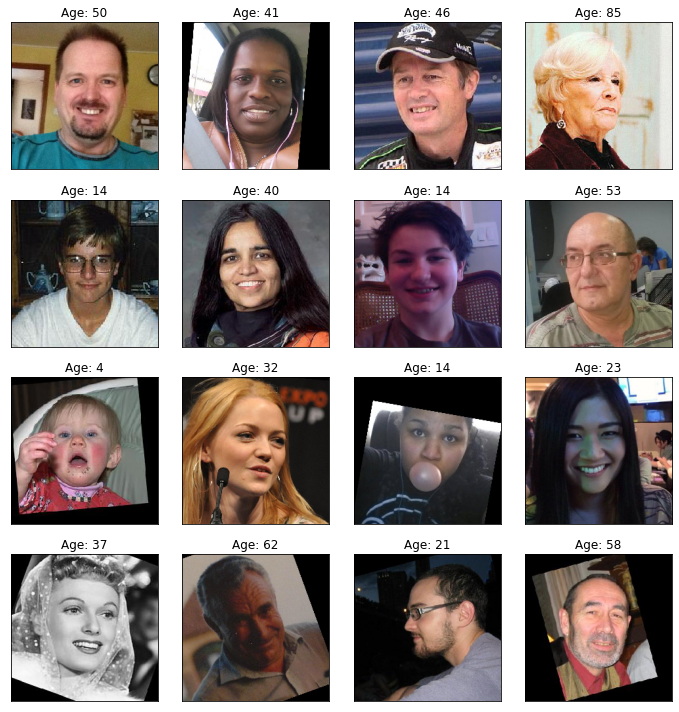

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Age: ' + str(target[i]))

Вывод:  Размер обучающей выборки 7591. В обучающей выборке содержатся как цветные, так и черно-белые фотографии. Стоит отметить, что на представленных данных имеются случаи поворота фотографий, добавления шума (черный фон на фотографиях),а также присутствуют другие люди на фоне. Возможно присутствие в датасете фотографий людей с головным убором, что может повлиять в дальнейшем на точность определения возраста.

## Обучение модели

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, directory=path + 'final_files/',
        x_col='file_name', y_col='real_age', target_size=(224, 224), batch_size=16, class_mode='raw',
        subset='training', seed=12345)

    return train_gen_flow

In [ ]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels, directory=path + 'final_files/',
        x_col='file_name', y_col='real_age', target_size=(224, 224), batch_size=16, class_mode='raw',
        subset='validation', seed=12345)

    return test_gen_flow

In [ ]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)

    return model

Train for 356 steps, validate for 119 steps

Epoch 1/20
356/356 - 111s - loss: 210.1661 - mae: 10.9853 - val_loss: 281.9823 - val_mae: 12.9941

Epoch 2/20

356/356 - 39s - loss: 138.1191 - mae: 9.0085 - val_loss: 218.6343 - val_mae: 11.0992

Epoch 3/20

356/356 - 39s - loss: 111.4412 - mae: 8.0588 - val_loss: 234.6798 - val_mae: 12.2956

Epoch 4/20

356/356 - 39s - loss: 93.8772 - mae: 7.4535 - val_loss: 140.0059 - val_mae: 9.3287

Epoch 5/20

356/356 - 39s - loss: 79.7509 - mae: 6.8895 - val_loss: 147.3897 - val_mae: 9.0396

Epoch 6/20

356/356 - 39s - loss: 69.3667 - mae: 6.3884 - val_loss: 113.7966 - val_mae: 8.4063

Epoch 7/20

356/356 - 39s - loss: 58.8026 - mae: 5.8732 - val_loss: 209.6284 - val_mae: 11.3143

Epoch 8/20

356/356 - 39s - loss: 51.9707 - mae: 5.5454 - val_loss: 124.7629 - val_mae: 8.4227

Epoch 9/20

356/356 - 39s - loss: 39.8943 - mae: 4.8794 - val_loss: 96.0737 - val_mae: 7.4726

Epoch 10/20

356/356 - 39s - loss: 36.8706 - mae: 4.6630 - val_loss: 169.9935 - val_mae: 10.4492

Epoch 11/20

356/356 - 39s - loss: 33.6807 - mae: 4.4631 - val_loss: 90.9979 - val_mae: 7.1145

Epoch 12/20

356/356 - 39s - loss: 28.9726 - mae: 4.1939 - val_loss: 90.7484 - val_mae: 7.1819

Epoch 13/20

356/356 - 39s - loss: 24.9921 - mae: 3.8490 - val_loss: 83.8340 - val_mae: 6.8499

Epoch 14/20

356/356 - 39s - loss: 22.5503 - mae: 3.6545 - val_loss: 84.9495 - val_mae: 6.9002

Epoch 15/20

356/356 - 39s - loss: 22.1560 - mae: 3.5962 - val_loss: 94.3861 - val_mae: 7.2516

Epoch 16/20

356/356 - 39s - loss: 19.5545 - mae: 3.4253 - val_loss: 106.4554 - val_mae: 7.8426

Epoch 17/20

356/356 - 39s - loss: 19.8504 - mae: 3.4389 - val_loss: 91.2440 - val_mae: 7.1252

Epoch 18/20

356/356 - 39s - loss: 20.0792 - mae: 3.4555 - val_loss: 97.2475 - val_mae: 7.3358

Epoch 19/20

356/356 - 39s - loss: 21.0006 - mae: 3.5328 - val_loss: 118.6022 - val_mae: 8.3487

Epoch 20/20

356/356 - 39s - loss: 17.9690 - mae: 3.2572 - val_loss: 102.8889 - val_mae: 7.8542 

119/119 - 10s - loss: 102.8889 - mae: 7.8542 

Test MAE: 7.8542 

**Вывод**

Изначально был проведен исследовательский анализ: он необходим для того, чтобы понять какими данными мы обладаем: есть ли в них выбросы, неточности в данных, какими распределениями обладают те или иные данные и т.п. Учитывая результаты исследования, можно повлиять на точность предсказаний модели, то есть на её качество.

Для обучения модели использовалась архитектура нейроной сети ResNet50, предобученная на датасете ImageNet. Данные были разделены в соотношении 3:1 на обучающие и валидационные. На тренировочной выборке использовалась аугментация.

Модель была обучена на 20 эпохах с шагом алгоритма оптимизации Adam 0.0005, для оценки функции потерь использовался MSE, чтобы нейронная сеть обучилась быстрее. На валидационных данных было получено значение метрики качества МАЕ = 7.8542(лет).

В дальнейшем рекомендуется провести анализ работы модели на разных возрастах, вдруг качество модели сильно отличается в зависимости от возраста.

Такая погрешность допустима при предсказании покупок для разных возрастных групп, но не допустима при анализе возраста человека, покупающего алкоголь.
